In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pickle
from sklearn.externals import joblib 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# 접속여부를 1주 단위로 비율로 표현
def week_login(data):
    for i in range(0,4):    
        data['week'+str(i+1)+'_log'] = (data[str(i+1)] + data[str(i+2)] + data[str(i+3)] + data[str(i+4)] + data[str(i+5)] + data[str(i+6)] + data[str(i+7)]) / 7
        
    data = data.drop(['1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'], axis=1)

    return data

# 데이터 불러오기
data = pd.read_csv('/content/drive/My Drive/merge_all_flatten.csv')    
train_label = pd.read_csv('/content/drive/My Drive/train_label_add.csv')
train_label = train_label.sort_values('acc_id')

# minuss, pluss에 비해 성능 떨어지는 컬럼 제거
del data['minus']
del data['plus']

# 위의 함수 적용
data = week_login(data)

# 과금 여부로 데이터 분류하기 위해 label 파일과 merge 
data_lbl = pd.merge(data, train_label, on='acc_id')

In [0]:
#가중치
data_lbl['w_amount_spent'] = data_lbl['amount_spent_y']*np.log(data_lbl['amount_spent_y']+1)*1.6

In [0]:
data_0 = data_lbl[data_lbl['amount_spent_y']>0].drop(['Unnamed: 0', 'survival_time', 'amount_spent_y', 'secession','w_amount_spent','total_spent'], axis=1)

In [8]:
# 데이터 샘플링
from sklearn.model_selection import train_test_split
ind = data_lbl.reset_index()
X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data_0[data_0.columns[1:]], data_lbl[data_lbl['amount_spent_y']>0]['w_amount_spent'], test_size=0.2, random_state=42)
#X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_ta.shape, X_test_ta.shape,y_train_ta.shape, y_test_ta.shape

((18849, 376), (4713, 376), (18849,), (4713,))

가중치 로그1.6으로 하면 test1의 고과금 분포가
떨어지고 1의 1이상 고과금 유저 분포사 올라감

In [0]:
# 1.6 가중치에 1 ~ 1.2 찾기

### from '과금유저_특성임계점찾기_0906.ipynb' ##
#가중치 적용 라벨 rmse:  3.782422232244276
#Thresh=mean, n=106,  rmse: 1.207450


# 가중치 적용 라벨 rmse:  3.8340910916235407
# Thresh=1.1*mean, n=94,  rmse: 1.096478

#가중치 적용 라벨 rmse:  3.7678681577184294
#Thresh=1.2*mean, n=86,  rmse: 1.185979

#가중치 적용 라벨 rmse:  3.7485768524426284
#Thresh=1.3*mean, n=79,  rmse: 1.234714

In [9]:
# 1.1mean 기준으로 세부 조정
%%time
# 일평균 결제량 가중치 로그*1.6 회귀 분석
from sklearn.model_selection import KFold

#threshholds = ["1.01*mean","1.02*mean", "1.03*mean","1.04*mean", "1.05*mean" , "1.06*mean", "1.07*mean","1.08*mean", "1.09*mean"]
threshholds = ["1.1*mean"]
# save list
features_index = []
features_name = []
predict_value = []
i = 0
for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      nthread = 15,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)
  
  print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  
  # feature name save
  feature_idx_all = select_ta.get_support()
  feature_name_all = data_0[data_0.columns[1:]].columns[feature_idx_all]
  
  # k_fold
  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # parameters
  xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(xgb_pars, dtrain, 1500,  watchlist,maximize=False, 
                        early_stopping_rounds = 50, verbose_eval=50)
  #
  #file_name = '/content/drive/My Drive/total_select'+str(i)+'_0906.pkl' 
  #joblib.dump(model, file_name)
  
  #file_name = '/content/drive/My Drive/total_model'+str(i)+'_0906.pkl' 
  #joblib.dump(select_ta, file_name)
  #i = i +1
  y_pred = model.predict(dtest)
  
  # 값 저장
  features_index.append(feature_idx_all)
  features_name.append(feature_name_all)
  predict_value.append(y_pred)
  
  #
  
  real = y_test_ta.reset_index()
  real['amount_spent_pred'] = y_pred
  linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
  spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
  linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

  print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
  print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:02:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (18849, 94)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.19348	valid-rmse:5.32742
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.99795	valid-rmse:5.16808
[100]	train-rmse:3.86111	valid-rmse:5.08158
[150]	train-rmse:3.74872	valid-rmse:5.05672
[200]	train-rmse:3.64254	valid-rmse:5.01931
Stopping. Best iteration:
[198]	train-rmse:3.64561	valid-rmse:5.01708

가중치 적용 라벨 rmse:  3.8340910916235407
Thresh=1.1*mean, n=94,  rmse: 1.096478
CPU times: user 33min 56s, sys: 26.2 s, total: 34min 23s
Wall time: 17min 31s


가중치 적용된 rmse 3.8340910916235407


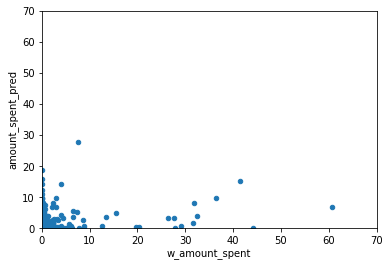

In [15]:
spent_compare.plot(kind='scatter', x='w_amount_spent', y = 'amount_spent_pred',alpha= 1)
print("가중치 적용된 rmse",linreg_RMSEk_w)
plt.axis([0, 70, 0, 70]); plt.show()

In [0]:
#real = y_test_ta.reset_index()
#real['amount_spent_pred'] = y_pred
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

1.096477793128836


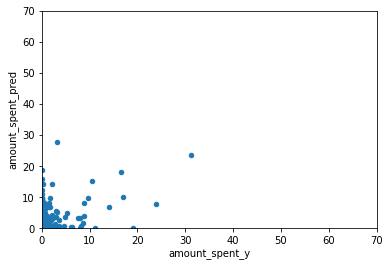

In [19]:
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
print(linreg_RMSEk)
plt.axis([0, 70, 0, 70]); plt.show()